In [1]:
from os import listdir

import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

from matplotlib import pyplot as plt

from ipynb.fs.full.GenerateLogs import generate_log

# Get Data
- Get data from 3 datasets
- Merge
- Shuffle
- Generate logs

In [2]:
# Load Datasets
data_path = '../data/'
datasets = ['lfw', 'cf']

names_path = lambda dataset_name: '%s%s-names.txt' % (data_path, dataset_name)
embeddings_path = lambda dataset_name: '%s%s_embeddings.npz' % (data_path, dataset_name)

# Return ids of images in each dataset as a list
def retrive_ids(filepath):
    with open(filepath, 'r') as file:
        ids = file.read().split()
    return ids

data_dfs = []
for name in datasets:
    data_df = pd.DataFrame(np.load(embeddings_path(name))['arr_0'])
    data_df['id'] = retrive_ids(names_path(name))
    
    data_dfs.append(data_df)
    
all_data_df = pd.concat(data_dfs)
all_data_df = all_data_df.sample(frac=1).reset_index(drop=True)
print('Dataset contains %s images of %s different people' % (len(all_data_df), len(all_data_df['id'].value_counts().keys())))

Dataset contains 24517 images of 6743 different people


In [4]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
results = []
for n in [50, 100, 250, 400]:
    log_length, n_people = 1000, n
    log = generate_log(all_data_df, log_length, n_people)
    
    # Do DBScan
    epsilon = 9.8
    X = log.drop(columns='id').values
    print('Log of length %d with %d unique faces' % (len(log), len(log['id'].value_counts().keys())))
    db = DBSCAN(eps=epsilon, min_samples=1).fit(X)
    labels = pd.Series(db.labels_)
    n_people = len(log['id'].value_counts().keys())
    n_clusters = len(list(labels.value_counts().values))
    est_error = (abs(n_clusters - n_people) / n_people) * 100
    print('eps: %f, people: %d clusters: %d error: %f\n' % (epsilon, n_people, n_clusters, est_error))

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(log.drop(columns='id').values)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    # unique colour for each person
    df = pd.DataFrame({'x':x, 'y':y})
    results.append(df)
#     plt.xlabel('Dimension 1')
#     plt.ylabel('Dimension 2')
#     plt.show()
    # plt.savefig('figs/tsne.png', dpi=100)

(Generating Log: len(df)=145, log_length=1000...Done.)
Log of length 1000 with 50 unique faces
eps: 9.800000, people: 50 clusters: 51 error: 2.000000

(Generating Log: len(df)=325, log_length=1000...Done.)
Log of length 1000 with 100 unique faces
eps: 9.800000, people: 100 clusters: 108 error: 8.000000

(Generating Log: len(df)=744, log_length=1000...Done.)
Log of length 1000 with 250 unique faces
eps: 9.800000, people: 250 clusters: 254 error: 1.600000

(Generating Log: len(df)=1351, log_length=1000...Done.)
Log of length 1000 with 400 unique faces
eps: 9.800000, people: 400 clusters: 380 error: 5.000000



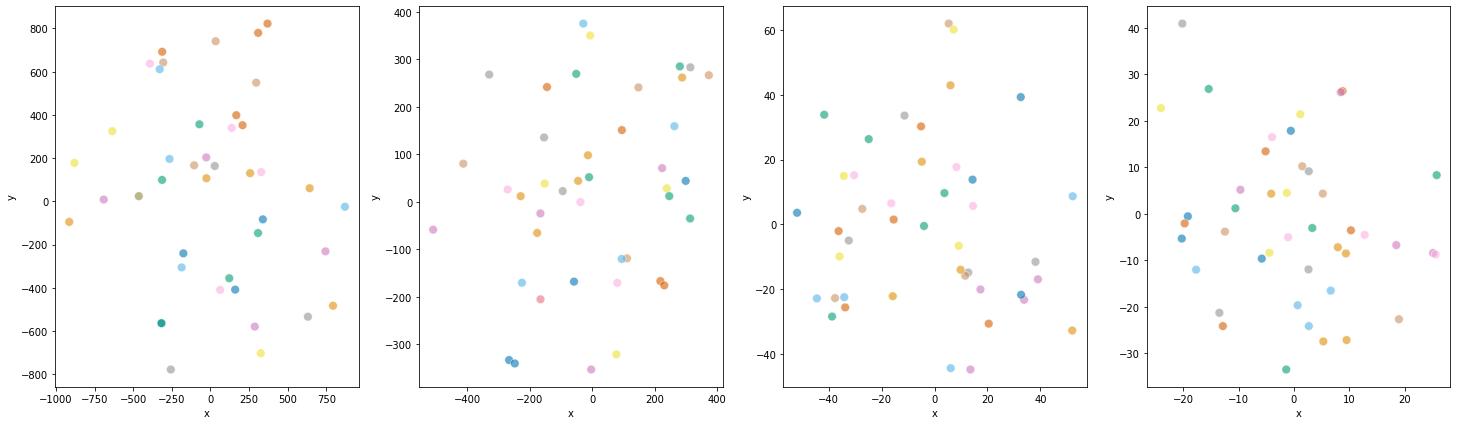

In [9]:
plt.figure(figsize=(25,7))

i = 1
for df in results:
    ax = plt.subplot(1, len(results), i)
    sns.scatterplot(
        x="x", y="y",
        hue=log['id'],
        palette=sns.color_palette("colorblind", log['id'].nunique()),
        data=df,
        legend=False,
        alpha=0.6,
        ax=ax,
        s=75
    )
    i+=1

In [196]:
""" Face Cluster """
import tensorflow as tf
import numpy as np
import importlib
import argparse
import os
import math

def face_distance(face_encodings, face_to_compare):
    """
    Given a list of face encodings, compare them to a known face encoding and get a euclidean distance
    for each comparison face. The distance tells you how similar the faces are.
    :param faces: List of face encodings to compare
    :param face_to_compare: A face encoding to compare against
    :return: A numpy ndarray with the distance for each face in the same order as the 'faces' array
    """
    import numpy as np
    if len(face_encodings) == 0:
        return np.empty((0))

    #return 1/np.linalg.norm(face_encodings - face_to_compare, axis=1)
    face_to_compare = np.array(face_to_compare)
    return np.sum(face_encodings*face_to_compare,axis=1)

def get_encoding_graph(encoding_list, threshold=0.75):
    """ Chinese Whispers Algorithm
    Modified from Alex Loveless' implementation,
    http://alexloveless.co.uk/data/chinese-whispers-graph-clustering-in-python/
    Inputs:
        encoding_list: a list of facial encodings from face_recognition
        threshold: facial match threshold,default 0.6
        iterations: since chinese whispers is an iterative algorithm, number of times to iterate
    Outputs:
        sorted_clusters: a list of clusters, a cluster being a list of imagepaths,
            sorted by largest cluster to smallest
    """

    #from face_recognition.api import _face_distance
    from random import shuffle
    import networkx as nx
    # Create graph
    nodes = []
    edges = []

    image_paths, encodings = zip(*encoding_list)

    if len(encodings) <= 1:
        print ("No enough encodings to cluster!")
        return []

    for idx, face_encoding_to_check in enumerate(encodings):
        # Adding node of facial encoding
        node_id = idx+1

        # Initialize 'cluster' to unique value (cluster of itself)
        node = (node_id, {'cluster': image_paths[idx], 'path': image_paths[idx]})
        nodes.append(node)

        # Facial encodings to compare
        if (idx+1) >= len(encodings):
            # Node is last element, don't create edge
            break

        compare_encodings = encodings[idx+1:]
        distances = face_distance(compare_encodings, face_encoding_to_check)
        encoding_edges = []
        for i, distance in enumerate(distances):
            if distance > threshold:
                # Add edge if facial match
                edge_id = idx+i+2
                encoding_edges.append((node_id, edge_id, {'weight': distance}))

        edges = edges + encoding_edges

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

def _chinese_whispers(encoding_list, threshold=0.01, iterations=20):
    """ Chinese Whispers Algorithm
    Modified from Alex Loveless' implementation,
    http://alexloveless.co.uk/data/chinese-whispers-graph-clustering-in-python/
    Inputs:
        encoding_list: a list of facial encodings from face_recognition
        threshold: facial match threshold,default 0.6
        iterations: since chinese whispers is an iterative algorithm, number of times to iterate
    Outputs:
        sorted_clusters: a list of clusters, a cluster being a list of imagepaths,
            sorted by largest cluster to smallest
    """

    #from face_recognition.api import _face_distance
    from random import shuffle
    import networkx as nx
    # Create graph
    nodes = []
    edges = []

    image_paths, encodings = zip(*encoding_list)

    if len(encodings) <= 1:
        print ("No enough encodings to cluster!")
        return []

    for idx, face_encoding_to_check in enumerate(encodings):
        # Adding node of facial encoding
        node_id = idx+1

        # Initialize 'cluster' to unique value (cluster of itself)
        node = (node_id, {'cluster': image_paths[idx], 'path': image_paths[idx]})
        nodes.append(node)

        # Facial encodings to compare
        if (idx+1) >= len(encodings):
            # Node is last element, don't create edge
            break

        compare_encodings = encodings[idx+1:]
        distances = face_distance(compare_encodings, face_encoding_to_check)
        encoding_edges = []
        for i, distance in enumerate(distances):
            if distance > threshold:
                # Add edge if facial match
                edge_id = idx+i+2
                encoding_edges.append((node_id, edge_id, {'weight': distance}))

        edges = edges + encoding_edges

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Iterate
    for _ in range(0, iterations):
        cluster_nodes = list(G.nodes)
        shuffle(cluster_nodes)
        for node in cluster_nodes:
            neighbors = G[node]
            clusters = {}

            for ne in neighbors:
                if isinstance(ne, int):
                    if G.nodes[ne]['cluster'] in clusters:
                        #该节点邻居节点的类别的权重
                        #对应上面的字典cluster的意思就是
                        #对应的某个路径下文件的权重
                        clusters[G.nodes[ne]['cluster']] += G[node][ne]['weight']
                    else:
                        clusters[G.nodes[ne]['cluster']] = G[node][ne]['weight']

            # find the class with the highest edge weight sum
            edge_weight_sum = 0
            max_cluster = 0
            #将邻居节点的权重最大值对应的文件路径给到当前节点
            for cluster in clusters:
                if clusters[cluster] > edge_weight_sum:
                    edge_weight_sum = clusters[cluster]
                    max_cluster = cluster

            # set the class of target node to the winning local class
            G.nodes[node]['cluster'] = max_cluster

    clusters = {}

    # Prepare cluster output
    for (_, data) in G.nodes.items():
        cluster = data['cluster']
        path = data['path']

        if cluster:
            if cluster not in clusters:
                clusters[cluster] = []
            clusters[cluster].append(path)

    # Sort cluster output
    sorted_clusters = sorted(clusters.values(), key=len, reverse=True)

    return sorted_clusters

def cluster_facial_encodings(facial_encodings):
    """ Cluster facial encodings
        Intended to be an optional switch for different clustering algorithms, as of right now
        only chinese whispers is available.
        Input:
            facial_encodings: (image_path, facial_encoding) dictionary of facial encodings
        Output:
            sorted_clusters: a list of clusters, a cluster being a list of imagepaths,
                sorted by largest cluster to smallest
    """

    if len(facial_encodings) <= 1:
        print ("Number of facial encodings must be greater than one, can't cluster")
        return []

    # Only use the chinese whispers algorithm for now
    sorted_clusters = _chinese_whispers(facial_encodings.items())
    return sorted_clusters


In [197]:
# Load Datasets
data_path = '../data/'
datasets = ['lfw', 'cf']

names_path = lambda dataset_name: '%s%s-names.txt' % (data_path, dataset_name)
embeddings_path = lambda dataset_name: '%s%s_embeddings.npz' % (data_path, dataset_name)

# Return ids of images in each dataset as a list
def retrive_ids(filepath):
    with open(filepath, 'r') as file:
        ids = file.read().split()
    return ids

data_dfs = []
for name in datasets:
    data_df = pd.DataFrame(np.load(embeddings_path(name))['arr_0'])
    data_df['id'] = retrive_ids(names_path(name))
    
    data_dfs.append(data_df)
    
all_data_df = pd.concat(data_dfs)
all_data_df = all_data_df.sample(frac=1).reset_index(drop=True).head(100)
print('Dataset contains %s images of %s different people' % (len(all_data_df), len(all_data_df['id'].value_counts().keys())))

Dataset contains 100 images of 96 different people


In [198]:
all_data_df['randNumCol'] = np.random.randint(1000, 9999, all_data_df.shape[0]).astype(str)
all_data_df['id'] = all_data_df['id'] + all_data_df['randNumCol']
all_data_df = all_data_df.drop(columns='randNumCol')

In [199]:
d = all_data_df.set_index('id').T.to_dict('list')

In [227]:
G = get_encoding_graph(d.items(), threshold=90)

chinese_whispers(G, weighting='top', iterations=20)

print(len(aggregate_clusters(G)))
print('ID\tCluster\n')
for label, cluster in sorted(aggregate_clusters(G).items(), key=lambda e: len(e[1]), reverse=True):
    print('{}\t{}\n'.format(label, cluster))

97
ID	Cluster

18	{10, 18, 76}

66	{66, 43}

1	{1}

2	{2}

3	{3}

4	{4}

5	{5}

6	{6}

7	{7}

8	{8}

9	{9}

11	{11}

12	{12}

13	{13}

14	{14}

15	{15}

16	{16}

17	{17}

19	{19}

20	{20}

21	{21}

22	{22}

23	{23}

24	{24}

25	{25}

26	{26}

27	{27}

28	{28}

29	{29}

30	{30}

31	{31}

32	{32}

33	{33}

34	{34}

35	{35}

36	{36}

37	{37}

38	{38}

39	{39}

40	{40}

41	{41}

42	{42}

44	{44}

45	{45}

46	{46}

47	{47}

48	{48}

49	{49}

50	{50}

51	{51}

52	{52}

53	{53}

54	{54}

55	{55}

56	{56}

57	{57}

58	{58}

59	{59}

60	{60}

61	{61}

62	{62}

63	{63}

64	{64}

65	{65}

67	{67}

68	{68}

69	{69}

70	{70}

71	{71}

72	{72}

73	{73}

74	{74}

75	{75}

77	{77}

78	{78}

79	{79}

80	{80}

81	{81}

82	{82}

83	{83}

84	{84}

85	{85}

86	{86}

87	{87}

88	{88}

89	{89}

90	{90}

91	{91}

92	{92}

93	{93}

94	{94}

95	{95}

96	{96}

97	{97}

98	{98}

99	{99}

100	{100}



In [233]:
# Load Datasets
data_path = '../data/'
datasets = ['lfw', 'cf']

names_path = lambda dataset_name: '%s%s-names.txt' % (data_path, dataset_name)
embeddings_path = lambda dataset_name: '%s%s_embeddings.npz' % (data_path, dataset_name)

# Return ids of images in each dataset as a list
def retrive_ids(filepath):
    with open(filepath, 'r') as file:
        ids = file.read().split()
    return ids

data_dfs = []
for name in datasets:
    data_df = pd.DataFrame(np.load(embeddings_path(name))['arr_0'])
    data_df['id'] = retrive_ids(names_path(name))
    data_dfs.append(data_df)   
all_data_df = pd.concat(data_dfs)
all_data_df = all_data_df.sample(frac=1).reset_index(drop=True).head(2000)
print('Dataset contains %s images of %s different people' % (len(all_data_df), len(all_data_df['id'].value_counts().keys())))

all_data_df['randNumCol'] = np.random.randint(1000, 9999, all_data_df.shape[0]).astype(str)
all_data_df['id'] = all_data_df['id'] + all_data_df['randNumCol']
all_data_df = all_data_df.drop(columns='randNumCol')

d = all_data_df.set_index('id').T.to_dict('list')
G = get_encoding_graph(d.items(), threshold=90)
chinese_whispers(G, weighting='top', iterations=20)

print(len(aggregate_clusters(G)))
print('ID\tCluster\n')
for label, cluster in sorted(aggregate_clusters(G).items(), key=lambda e: len(e[1]), reverse=True):
    print('{}\t{}\n'.format(label, cluster))

Dataset contains 2000 images of 1360 different people
1459
ID	Cluster

1735	{384, 129, 1536, 1411, 1400, 646, 774, 1297, 790, 410, 154, 670, 1440, 1700, 166, 555, 1837, 1198, 178, 1717, 571, 60, 1725, 702, 450, 1476, 1735, 712, 78, 590, 592, 1360, 850, 1115, 1499, 1502, 1119, 1758, 481, 867, 376, 1379, 745, 234, 750, 1399, 504, 252, 254}

721	{995, 228, 1508, 1481, 1577, 1789, 1803, 721, 1106, 1300, 664, 313, 91, 93, 894, 735}

1884	{1792, 1697, 1670, 1352, 1675, 879, 880, 1905, 851, 1011, 1884}

1634	{1634, 1540, 1671, 1033, 1324, 81, 181, 1078, 791, 668}

133	{133, 1191, 296, 139, 689, 1587, 1525, 764, 862}

1253	{1380, 1253, 1445, 363, 1356, 1694, 1391, 731, 414}

694	{1699, 1254, 103, 365, 1522, 1589, 694, 1144}

1807	{1472, 1537, 1382, 1807, 981, 24, 1724}

740	{740, 351, 1618, 467, 127, 1598, 991}

1978	{832, 1569, 1978, 1318, 1286, 1873, 1818}

937	{355, 5, 937, 73, 1678, 1726}

96	{96, 163, 998, 1162, 107, 1109}

1420	{1719, 1420, 142, 631, 1148, 572}

1045	{419, 804, 357, 815,

In [ ]:
#  forget to made the two same,I will make the two the same,
# but the threshold depends on your own model,which mean>Threshold
# (the code use cosin similarity,which means,the closer to 1.0 the more similarity) you will think it is the same person